In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define functions, load data

## 1.1. Import interactive maps module

In [3]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [4]:
# Function for displaying the map

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 1.2. Define functions for calculating distance on Earth

In [5]:
# Using geopy
import geopy.distance

def dist(a, b):
    return geopy.distance.geodesic((a.x, a.y), (b.x, b.y)).km

In [6]:
# Using geopandas
def dist_2(a, b):
    a = gpd.GeoSeries(Point(a.y, a.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    b = gpd.GeoSeries(Point(b.y, b.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    return a.distance(b) / 1000

## 1.3. Load DataFrames for `apartaments` and `metro`

In [7]:
apartaments = pd.read_csv("apartaments.csv")
metro = pd.read_csv("metro.csv")

# 2. Prepare data

## 2.1. Add `price` to `rental price` in order to get `real price`

In [8]:
# Function to check if value is Nan or not
def notNan(a):
    return a == a

In [9]:
def real_price(row):
    if notNan(row['Czynsz - dodatkowo']):
        return int(row['Cena']) + int(row['Czynsz - dodatkowo'])
    else:
        return int(row['Cena'])

In [10]:
if 'Cena rzeczywista' in apartaments or not 'Cena' in apartaments:
    print("Reloading apartamens.csv file")
    apartaments = pd.read_csv("apartaments.csv")
    
apartaments.insert(1, "Cena rzeczywista", apartaments.apply(real_price, axis=1))
#apartaments = apartaments.drop(columns = ['Cena', 'Czynsz - dodatkowo'])

## 2.2. Find distance to nearest metro station for all valid houses

In [11]:
nearest_metro_dist = []
nearest_metro_name = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        list_ = [dist(Point(house['φ'], house['λ']), Point(station['φ'], station['λ']))
                 for jdx, station in metro.iterrows()]
        nearest_metro_dist.append(round(min(list_), 4))
        nearest_metro_name.append(metro.iloc[np.argmin(list_)]['Nazwa'])
    else:
        nearest_metro_dist.append(np.nan)
        nearest_metro_name.append(np.nan)
        
        
if "Odległość od najbliższej stacji metra" in apartaments:
    apartaments = apartaments.drop('Odległość od najbliższej stacji metra', axis=1)
apartaments.insert(apartaments.shape[1], "Odległość od najbliższej stacji metra", nearest_metro_dist)

if "Najbliższa stacja metra" in apartaments:
    apartaments = apartaments.drop('Najbliższa stacja metra', axis=1)
apartaments.insert(apartaments.shape[1], "Najbliższa stacja metra", nearest_metro_name)

## 2.3. Find distance to city center (`PKiN`) for all valid houses

In [12]:
city_center_dist = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        city_center_dist.append(round(dist(Point(house['φ'], house['λ']), Point(52.2323, 21.0000)), 4))
    else:
        city_center_dist.append(np.nan)
        
        
if "Odległość od centrum" in apartaments:
    apartaments = apartaments.drop("Odległość od centrum", axis=1) 
apartaments.insert(apartaments.shape[1], "Odległość od centrum", city_center_dist) 

## 2.4. Read districts' shape data

In [13]:
geo = gpd.read_file("districts/warszawa_dzielnice.shp").to_crs({'init': 'epsg:4326'})
geo = geo.drop(0).reset_index().drop(columns=['index', 'cartodb_id'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## 2.5. Assign districts to all houses

In [14]:
def assign_district(row):
    point = Point(row['λ'], row['φ'])
    if notNan(row['φ']):
        return np.argmax([polygon.contains(point) for polygon in geo['geometry']])
    else:
        return np.nan

apartaments['Numer dzielnicy'] = apartaments.apply(assign_district, axis=1)
apartaments['Nazwa dzielnicy'] = apartaments['Numer dzielnicy'].apply(
    lambda x: geo.iloc[int(x)]['name'] if notNan(x) else np.nan)

# 3. Analyse dataset

In [121]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,λ,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,21.066343,NaN,NaN,NaN,NaN,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,20.930776,500.0,5.0,cegła,2014.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,21.044630,NaN,6.0,pustak,2018.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,21.054128,400.0,5.0,NaN,2007.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,21.082662,350.0,4.0,cegła,2016.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.1. Price boxplot for each district

Text(0, 0.5, 'Cena [zł]')

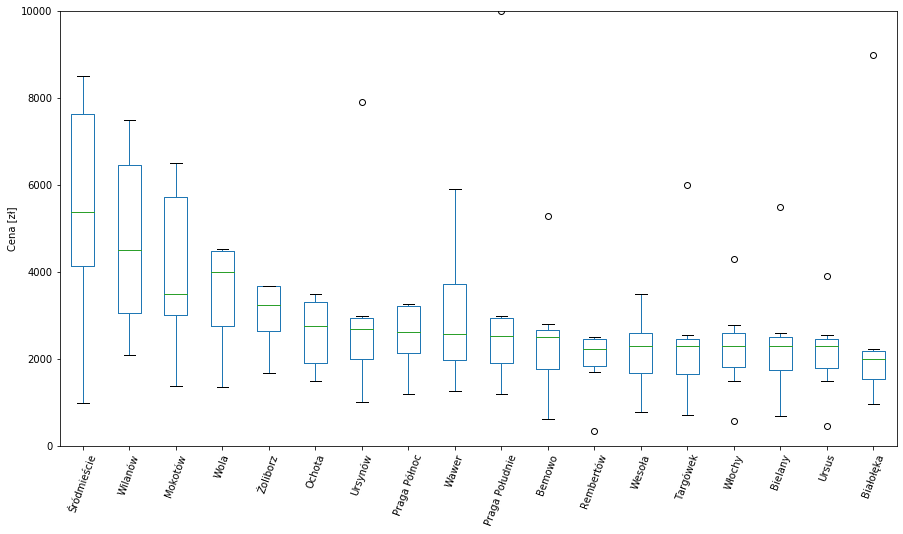

In [28]:
apartaments.groupby('Nazwa dzielnicy')['Cena'].describe().drop(['count'], axis=1).sort_values(by='50%', ascending=False).T.plot.box(figsize=(15,8))
plt.ylim(0, 10000)
plt.xticks(rotation=70)
plt.ylabel('Cena [zł]')

## 3.2. Show median price for each district

In [16]:
plot_dict = apartaments.groupby('Numer dzielnicy')['Cena'].describe()['50%']
plot_dict.index = [str(i) for i in range(0,18)]

In [17]:
apartaments.groupby('Nazwa dzielnicy')['Cena'].describe()['50%'].astype('int32').rename('Mediana cen [zł]').sort_values()

Nazwa dzielnicy
Białołęka         2000
Targówek          2300
Bielany           2300
Włochy            2300
Wesoła            2300
Ursus             2300
Rembertów         2400
Bemowo            2500
Praga Południe    2525
Wawer             2575
Praga Północ      2625
Ursynów           2700
Ochota            2750
Żoliborz          2800
Wola              3000
Mokotów           3500
Wilanów           4500
Śródmieście       5200
Name: Mediana cen [zł], dtype: int32

In [18]:
# Create a base map
m_1 = folium.Map(location=[52.2323,21.0000], tiles='cartodbpositron', zoom_start=10)

# Add apartaments to the map
mc = MarkerCluster()
for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        mc.add_child(Marker([house['φ'], house['λ']], popup=str(house['Cena rzeczywista']) + "zł"))
m_1.add_child(mc)

# Add districts coloured by median price to the map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Mediana cen [zł]',
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

## 3.3. Correlate data

In [112]:
df = apartaments[['Cena rzeczywista', 'Liczba pokoi', 'Piętro', 'Powierzchnia',
                  'Odległość od najbliższej stacji metra', 'Odległość od centrum', 'Nazwa dzielnicy', 'Rok budowy']]

# Apply relevant conditions

df = df[df['Odległość od centrum'] < 20]
#df = df[df['Odległość od centrum'] > 1]
df = df[df['Cena rzeczywista'] < 20000]
#df = df[df['Powierzchnia'] <= 80]
#df = df[df['Nazwa dzielnicy'] != 'Wilanów']
#df = df[df['Nazwa dzielnicy'] != 'Wawer']
df = df[df['Liczba pokoi'] != "więcej niż 10"]
df['Liczba pokoi'] = df['Liczba pokoi'].astype('int32')

df.corr()

,Cena rzeczywista,Liczba pokoi,Powierzchnia,Odległość od najbliższej stacji metra,Odległość od centrum,Rok budowy
Cena rzeczywista,1.000000,0.622343,0.816472,-0.220691,-0.260170,0.037892
Liczba pokoi,0.622343,1.000000,0.821327,-0.034050,0.013524,0.023584
Powierzchnia,0.816472,0.821327,1.000000,-0.082253,-0.039270,0.019693
Odległość od najbliższej stacji metra,-0.220691,-0.034050,-0.082253,1.000000,0.609436,0.197601
Odległość od centrum,-0.260170,0.013524,-0.039270,0.609436,1.000000,0.259209
Rok budowy,0.037892,0.023584,0.019693,0.197601,0.259209,1.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

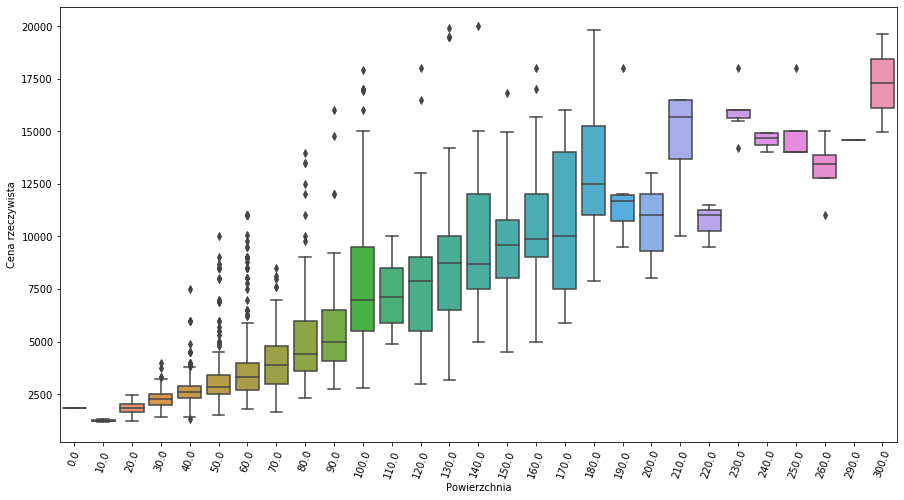

In [113]:
plt.figure(figsize=(15,8))
sns.boxplot('Powierzchnia', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/10)*10 if x.name == 'Powierzchnia' else x))
plt.xticks(rotation=70)
#plt.ylim(0, 7500)

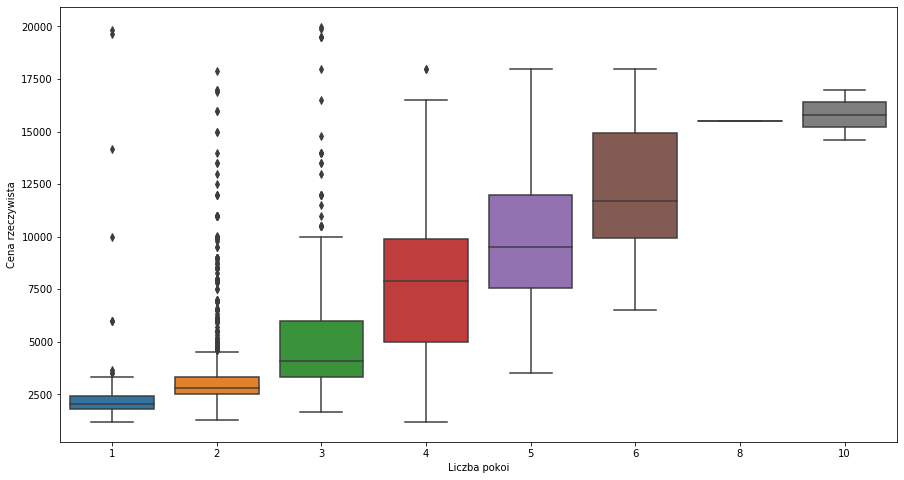

In [114]:
plt.figure(figsize=(15,8))
sns.boxplot('Liczba pokoi', 'Cena rzeczywista', data=df)
#plt.ylim(0, 5000)

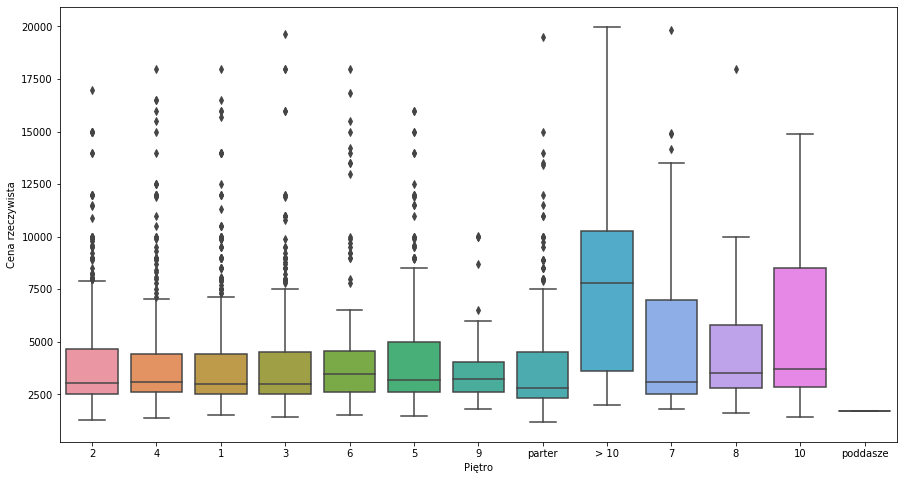

In [115]:
plt.figure(figsize=(15,8))
sns.boxplot('Piętro', 'Cena rzeczywista', data=df)

(1000, 12000)

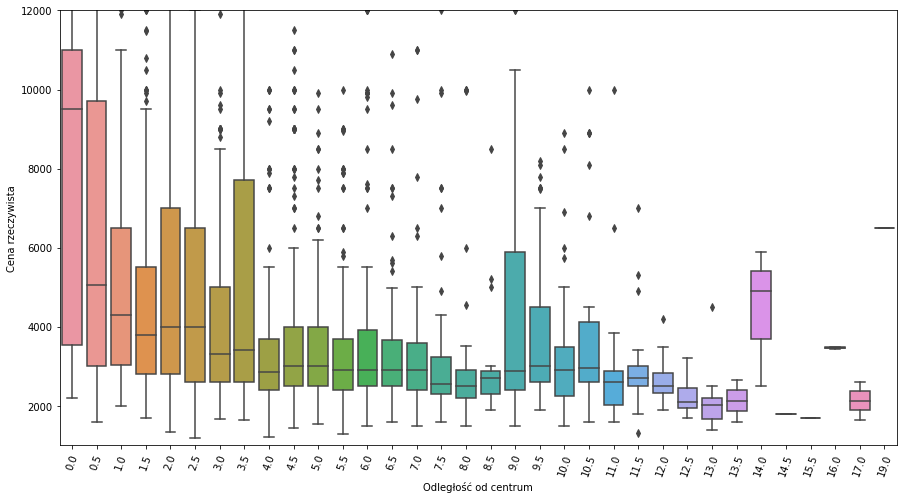

In [116]:
plt.figure(figsize=(15,8))
sns.boxplot('Odległość od centrum', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od centrum' else x))
plt.xticks(rotation=70)
plt.ylim(1000, 12000)

(1000, 7500)

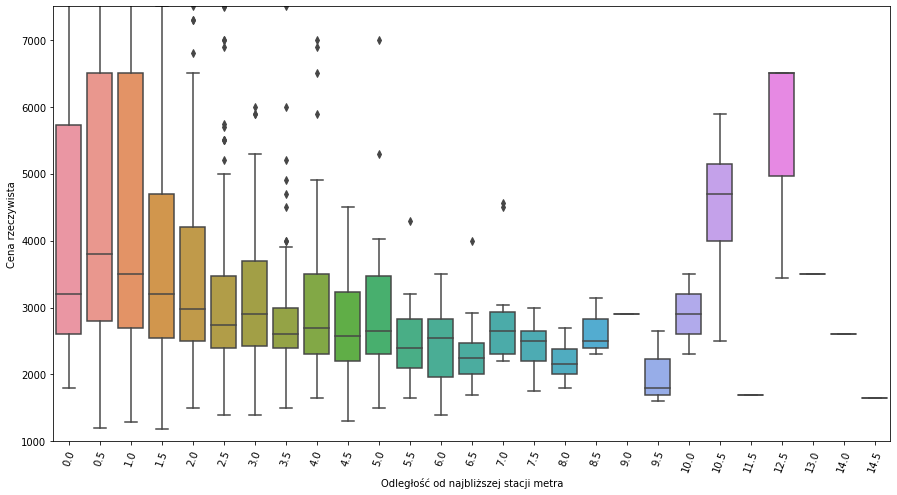

In [117]:
plt.figure(figsize=(15,8))
sns.boxplot('Odległość od najbliższej stacji metra', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od najbliższej stacji metra' else x))
plt.xticks(rotation=70)
plt.ylim(1000, 7500)

Text(0, 0.5, 'Odległość od centrum [km]')

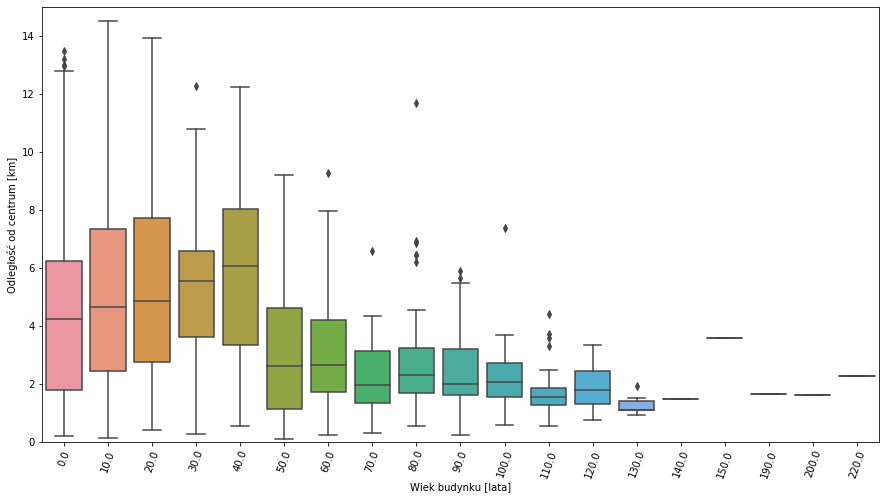

In [118]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Odległość od centrum', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x))
plt.xticks(rotation=70)
plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Odległość od centrum [km]')

## Comments:
- `price` and `area of house` relation is `strongly linear`
- `price` and `number of rooms` relation is `strongly linear`
- there is `no relation` between `price` and `floor number`
- there is `some correlation` between `price` and `distance to city center`, aswell as between `nearest metro station location` and `price`. Noticably, there is a peak of price at a distance `~9 km` from city center. It's because exactly in `9 km` there is district `Wilanów`, which is a rich quarter of Warsaw and its prices are not connected with commutation. Peaks at `10.5 km` and `12.5 km` at `nearest metro station location` plot are caused by single houses at district `Wawer` and can be ignored.
- analysing `year of build` and `distance from city center` leads to conclusion, that Warsaw was destroyed in WWII and is being rebuilded starting from city center to `outside direction`

# 3.4. Distribution of apartment's floor level

Text(0, 0.5, 'Ilość mieszkań')

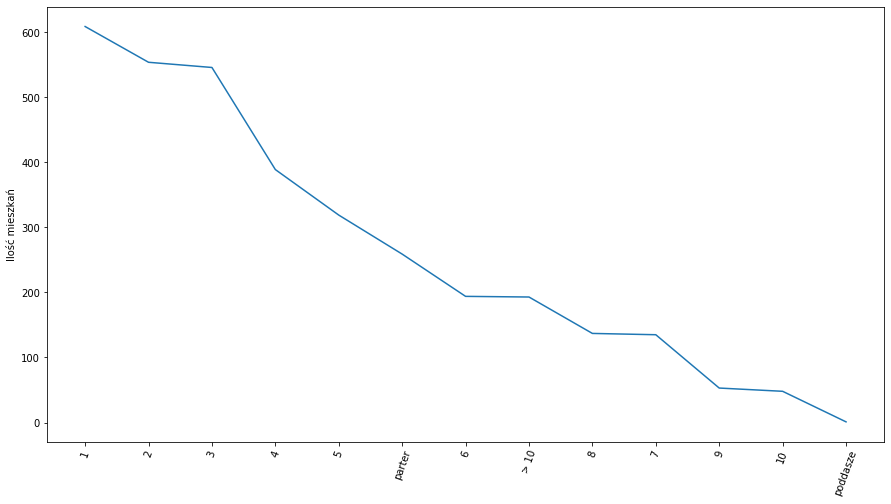

In [119]:
plt.figure(figsize=(15,8))
plt.plot(apartaments['Piętro'].value_counts())
plt.xticks(rotation=70)
plt.ylabel('Ilość mieszkań')

## Comment:
Most apartaments are suprisingly located not on the `groud floor` (parter), but rather on 1st, 2nd or 3rd floor.